In [411]:
import pandas as pd
import numpy as np

#Modelisation
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lars

#Fonction test model
from Test_Model import test_model
%matplotlib inline

# III/ Comparaison de l'erreur de prédiction de différentes méthodes statistiques

Jusqu'à maintenant, nous avons démontré que les stratégies d'investissements obtenues à partir de la résolution du problème de Markovitz (équivalent à la résolution d'un problème des moindres carrés => démonstration dans le fichier LaTeX) ne sont pas très convaincantes. Nous allons donc tester plusieurs autres méthodes statistiques de prédiction des rendements futurs et allons mettre en place une métrique commune qui mesure l'erreur de prédiction obtenue. 



Ici on crée l'interface qui nous permet de choisir le nombre d'actifs considéré, le nombre de dates, la vraie loi des rendements

In [255]:
nb_actifs = 20
nb_dates = 256 * 5

idx = pd.Index(np.arange(nb_actifs))
idx_date = pd.Index(np.arange(nb_dates))

esp_rdt = 0.05
vol_rdt = 0.2
correl = 0.7
seuil_pb_marko = 0.05
mu = pd.Series(esp_rdt,index=idx)
vols = pd.Series(vol_rdt,index=idx)
#Le vecteur constant cible que l'on essayer d'estimer -> chaque composante du vecteur est le rendement du protefeuille optimal tous  les jours
allocation_optimale_théorique = pd.Series(esp_rdt, index = idx_date)

#Matrice var-covar théorique selon la vraie loi des rendements
covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vols)

In [256]:
#On simuler un tirage de rendements suivant une loi normale d'espérence Mu et de Var la matrice Covar
A = np.linalg.cholesky(covar)
rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16

Ici on calcule les estimateurs d'espérance et de variance empiriques de la série des observations

In [257]:
mu_estime = rdts_observes.mean() * 256
covar_estimee = rdts_observes.cov() * 256

#Suivant la formule de la résolution du problème, on calcule l'allocation optimale "in sample"

covar_inv = np.linalg.inv(covar_estimee)
df_covar_inv = pd.DataFrame(covar_inv,index=idx,columns=idx)
lambda1 = seuil_pb_marko/(mu_estime @ df_covar_inv @ mu_estime)
alloc_optimale_in_sample = lambda1 * (df_covar_inv @ mu_estime)

A priori, nous pouvons nous ramener à la résolution d'un problème des moindres carrés. Donc nous allons effectuer la régression de la vraie allocation optimale sur les rendements observés. Le Beta que l'on obtient devrait être le plus proche possible de l'allocation optimale théorique. 

In [258]:
print(allocation_optimale_théorique)

0       0.05
1       0.05
2       0.05
3       0.05
4       0.05
        ... 
1275    0.05
1276    0.05
1277    0.05
1278    0.05
1279    0.05
Length: 1280, dtype: float64


In [259]:
regression = LinearRegression()

# Entraîner le modèle sur les données
regression.fit(rdts_observes, allocation_optimale_théorique)

# Obtenir les coefficients de la régression
coefficients = regression.coef_
intercept = regression.intercept_

On réalise la régression sans intercept car la variable sur laquelle on régresse est colinéaire avec le vecteur constant égale à 1

In [260]:
regression_sans_intercept = LinearRegression(fit_intercept = False)

# Entraîner le modèle sur les données
regression_sans_intercept.fit(rdts_observes, allocation_optimale_théorique)

# Obtenir les coefficients de la régression
coefficients_bis = regression_sans_intercept.coef_
intercept_bis = regression_sans_intercept.intercept_

On normalise le vecteur d'allocation entre les actifs in sample afin que la somme de ses poids soit égale à 1 et pareil pour le vecteur des coefficients qui sort de la régression sans intercept. 

On voit que l'on retrouve bien l'allocation in sample de la partie I. 

In [261]:
#Coefficients problème de Markovitz
alloc_optimale_in_sample_normalized = alloc_optimale_in_sample * (1 / sum(alloc_optimale_in_sample))
#Coefficients issues de la régression
coefficients_bis_normalized = coefficients_bis * (1 / sum(coefficients_bis))

print(alloc_optimale_in_sample_normalized - coefficients_bis_normalized)

0    -7.659651e-12
1    -1.470823e-12
2     4.412470e-12
3    -1.430855e-12
4    -1.465494e-12
5     1.756817e-12
6     3.973710e-12
7    -3.145928e-12
8     2.790657e-12
9     8.646417e-13
10   -1.092459e-12
11    3.996803e-12
12    5.426770e-13
13   -2.790657e-12
14   -3.288037e-12
15    1.239009e-12
16    3.859135e-13
17    1.519673e-12
18    1.760370e-12
19   -9.023893e-13
dtype: float64


## A/ Régressions pénalisées

Dans cette partie, nous allons tester des régressions pénalisées afin de pouvoir comparer l'erreur de prédiction avec les précédentes méthodes

### 1/ Création des échantillons train/test

Ici, nous allons régresser le vecteur "allocation_optimale_theorique" qui est un vecteur colinéaire au vecteur constant égal à 1 et qui contient la performance, jour par jour, du portfolio optimal dans notre exemple

In [344]:
nb_dates_test = 256
nb_simu = 1000

In [345]:
X_train = rdts_observes
Y_train = allocation_optimale_théorique * 20

X_test = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
Y_test = allocation_optimale_théorique[:256] #Car les lois des actifs n'ont pas été modifiées

In [346]:
def test_model_NB(X_train, X_test, y_train, y_test, DF, model) : 

    #on run le modèle avec les fonctions prebuilt
    ols =  model.fit(X_train, y_train)
    y_pred = ols.predict(X_test)

    #On affiche le R^2 du modèle calculé à partir des échantillons Train -> pourquoi est ce que c'est n'importe quoi ? 
    print("R_2 du modèle : " +str(ols.score(X_train, y_train)))
    print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred, y_test)}")
    print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred, y_test)}")


    coefs = pd.DataFrame(ols.coef_, columns=['Coefficients'], index = DF.columns)
    coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
    coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
    plt.title('Régression linéaire')
    plt.axvline(x=0, color='1')
    plt.grid()
    plt.subplots_adjust(left=.3)

    return f"l'allocation optimale selon ce modèle est {ols.coef_}"

R_2 du modèle : 0.0
Le MSE (Mean Squared Error) de notre prédiction est de 0.009062026747186718
Le MAE (Mean Absolute Error) de notre prédiction est de 0.07433107865589128


"l'allocation optimale selon ce modèle est [ 7.41260204  1.44704926 -4.28206172  1.38545268  1.40461191 -1.71600145\n -3.80132721  2.9764272  -2.7424957  -0.82716816  1.04084667 -3.89256815\n -0.57483612  2.67238093  3.13403067 -1.24598299 -0.39213469 -1.41329007\n -1.64894629  0.79250883]"

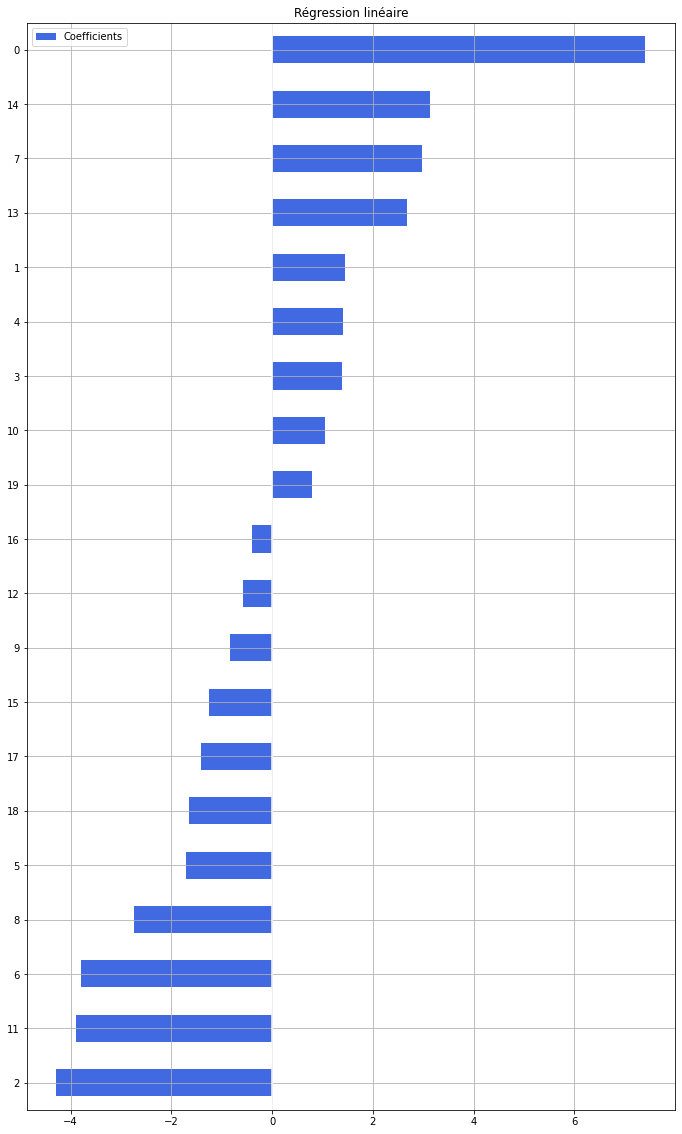

In [347]:
test_model_NB(X_train, X_test, Y_train, Y_test, X_train, LinearRegression(fit_intercept = False))

Le MSE (Mean Squared Error) de notre prédiction est de 0.009062026747186718
Le MAE (Mean Absolute Error) de notre prédiction est de 0.07433107865589128
[ 27.36263493   5.34158996 -15.80666153   5.11421438   5.18493812
  -6.33439121 -14.03209402  10.98708531 -10.12355826  -3.05338128
   3.84214709 -14.36889779  -2.12193112   9.8647389   11.56885755
  -4.59938055  -1.44751306  -5.2169724   -6.086866     2.925441  ]


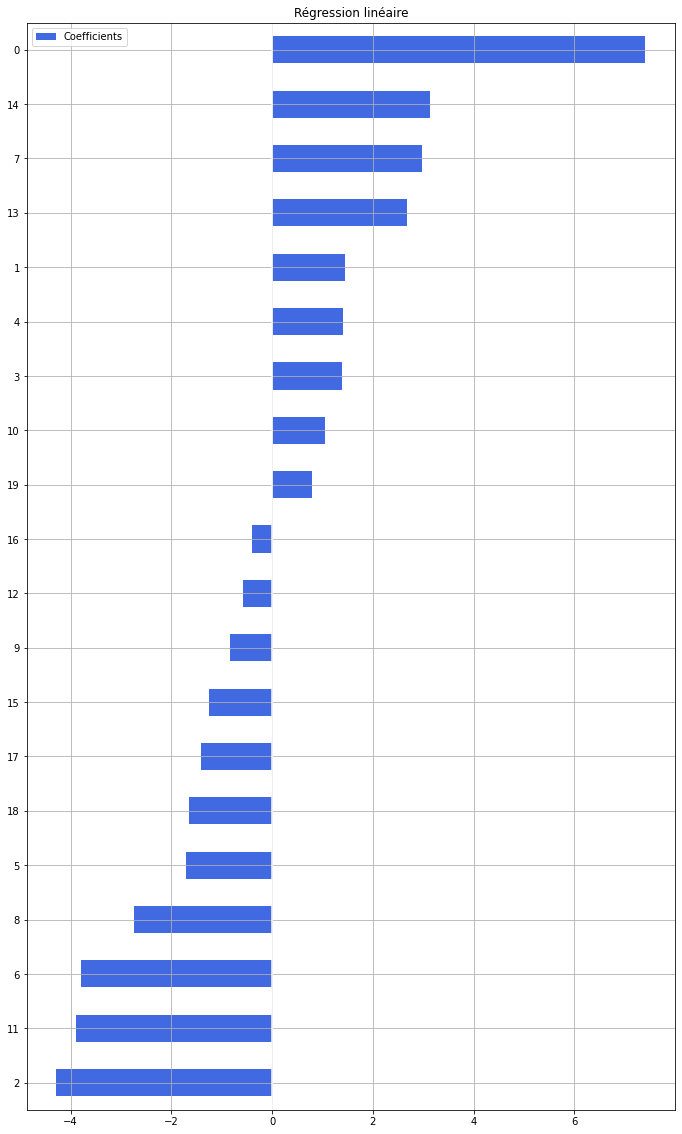

In [461]:
reg = LinearRegression(fit_intercept = False)
model =  reg.fit(X_train, Y_train)
coef_reglin = model.coef_
y_pred = model.predict(X_test)

print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred, Y_test)}")
print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred, Y_test)}")

coefs = pd.DataFrame(coef_reglin, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_reg_lin_normalized = coef_reglin * abs(1/sum(coef_reglin))
print(coef_reg_lin_normalized)

On affiche les PNL in sample

Sharpe = 1.3767695127002282


<AxesSubplot:>

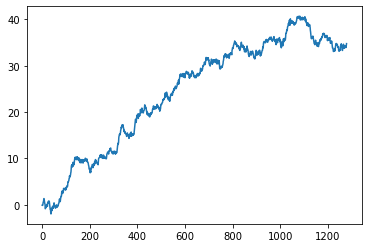

In [462]:
pnl_in_sample_reglin = rdts_observes @ coef_reg_lin_normalized
print('Sharpe = ' + str(pnl_in_sample_reglin.mean()/pnl_in_sample_reglin.std()*16))
pnl_in_sample_reglin.cumsum().plot()

Maintenant, testons les 2 portefeuilles out-sample

Sharpe = 1.1311445609914468


<AxesSubplot:>

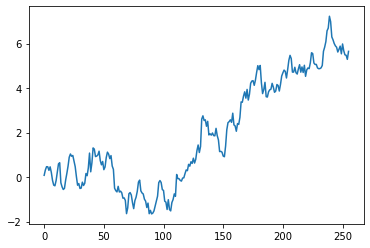

In [465]:
pnl_test_reglin = X_test @ coef_reg_lin_normalized
print('Sharpe = ' + str(pnl_test_reglin.mean()/pnl_test_reglin.std()*16))
pnl_test_reglin.cumsum().plot()

Maintenant, nous allons simuler plusieurs échantillons test et voir, en moyenne, comment se comporte notre portefeuille

In [351]:
pnl_out_sample_reglin = []
sharpe_out_sample_reglin = []

for i in range(nb_simu) : 
    simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
    pnl_simu = simu @ coef_reg_lin_normalized
    pnl_out_sample_reglin.append(pnl_simu)

    sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
    sharpe_out_sample_reglin.append(sharpe_simu)

sharpe_out_sample_DF_reglin = pd.DataFrame(sharpe_out_sample_reglin)
sharpe_out_sample_DF_reglin.describe()
    

,0
count,1000.000000
mean,-0.056193
std,1.024649
min,-3.523911
25%,-0.736626
50%,-0.075802
75%,0.662016
max,3.285163


On affiche les quantiles des sharpe ratio de toutes nos simulations et on trace la moyenne afin de voir le sharpe moyen que nous apporte notre portfolio

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2877958211.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF_reglin.mean())


Voici le sharpe moyen de cette méthode -0.056193243677596684


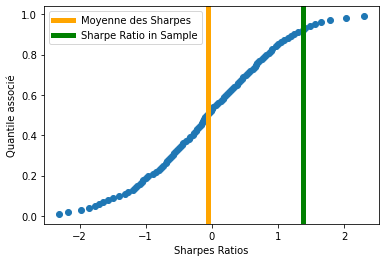

In [369]:
quantiles = sharpe_out_sample_DF_reglin.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])

moyenne_sharpe = float(sharpe_out_sample_DF_reglin.mean())
sharpe_in_sample = pnl_in_sample_reglin.mean()/pnl_in_sample_reglin.std()*16
plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')
plt.axvline(x=sharpe_in_sample, color='green', linestyle='-', linewidth=5,  label='Sharpe Ratio in Sample')

plt.xlabel('Sharpes Ratios')
plt.ylabel('Quantile associé')
plt.legend()
#plt.scatter(quantiles['quantile']*0 + sharpe_out_sample_DF.mean(),quantiles['proba'])
#plt.scatter(quantiles['quantile']*0 + pnl_in_sample.mean()/pnl_in_sample.std()*16,quantiles['proba'])
print(f"Voici le sharpe moyen de cette méthode {moyenne_sharpe}")

Désormais, nous allons faire la même chose avec les régressions pénalisées

Le MSE (Mean Squared Error) de notre prédiction est de 0.009062026747186718
Le MAE (Mean Absolute Error) de notre prédiction est de 0.07433107865589128
[ 7.28355836  1.1741871  -4.17467815  1.46558463  0.86105933 -1.65303604
 -3.74431799  2.64783241 -2.47356096 -0.70826929  1.13457645 -4.05152748
 -0.54579644  2.5558027   3.16738835 -1.28302577 -0.48571434 -1.57161687
 -1.60577666  1.00733065]


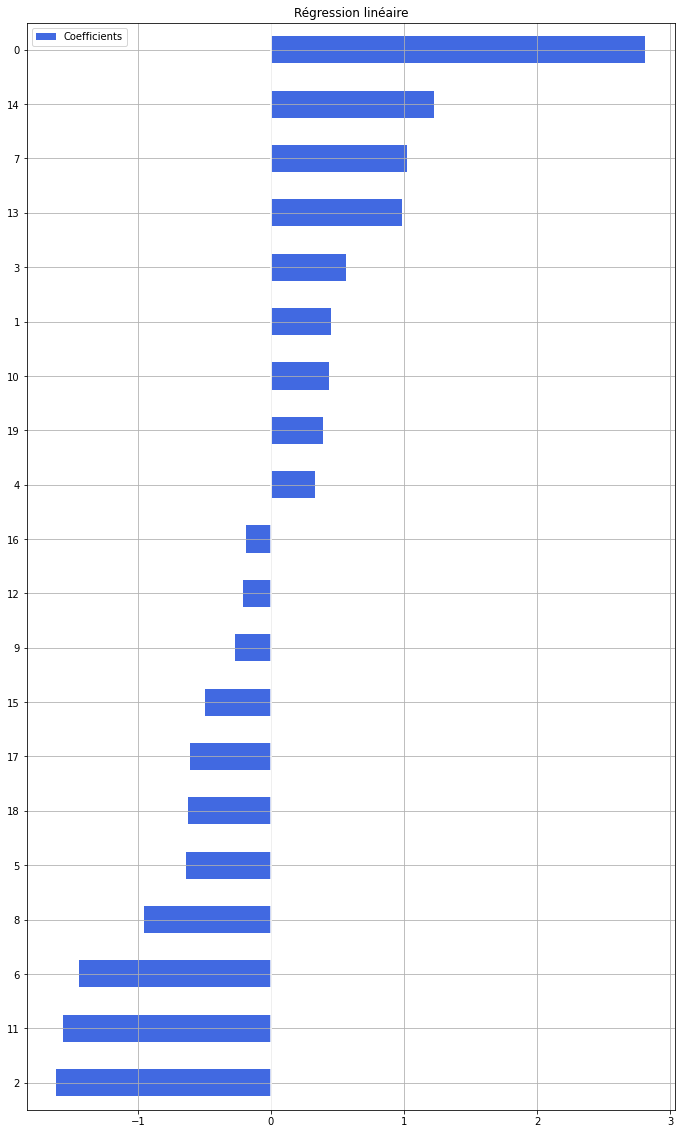

In [355]:
ridge = RidgeCV(fit_intercept = False, cv = 5)
model_ridge =  ridge.fit(X_train, Y_train)
coef_ridge = model_ridge.coef_
y_pred_ridge = model.predict(X_test)

print(f"Le MSE (Mean Squared Error) de notre prédiction est de {mean_squared_error(y_pred_ridge, Y_test)}")
print(f"Le MAE (Mean Absolute Error) de notre prédiction est de {mean_absolute_error(y_pred_ridge, Y_test)}")

coefs = pd.DataFrame(coef_ridge, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_ridge_normalized = coef_ridge * abs(1/sum(coef_ridge))
print(coef_ridge_normalized)

Sharpe = 1.3680910712007535


<AxesSubplot:>

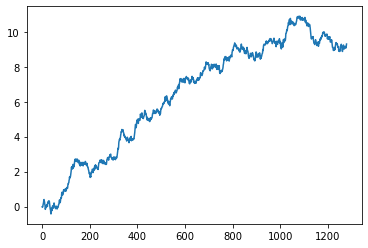

In [356]:
pnl_in_sample_ridge = rdts_observes @ coef_ridge_normalized
print('Sharpe = ' + str(pnl_in_sample_ridge.mean()/pnl_in_sample_ridge.std()*16))
pnl_in_sample_ridge.cumsum().plot()

Sharpe = 1.0964897625925891


<AxesSubplot:>

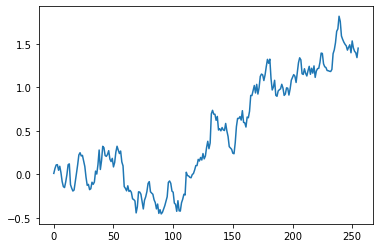

In [357]:
pnl_test_ridge = X_test @ coef_ridge_normalized
print('Sharpe = ' + str(pnl_test_ridge.mean()/pnl_test_ridge.std()*16))
pnl_test_ridge.cumsum().plot()

In [358]:
pnl_out_sample_ridge = []
sharpe_out_sample_ridge = []

for i in range(nb_simu) : 
    simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
    pnl_simu = simu @ coef_ridge_normalized
    pnl_out_sample_ridge.append(pnl_simu)

    sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
    sharpe_out_sample_ridge.append(sharpe_simu)

sharpe_out_sample_DF_ridge = pd.DataFrame(sharpe_out_sample_ridge)
sharpe_out_sample_DF_ridge.describe()

,0
count,1000.000000
mean,-0.023099
std,0.960457
min,-3.511220
25%,-0.680663
50%,-0.054800
75%,0.637261
max,3.068802


Voici le sharpe moyen de cette méthode -0.023098584577871225


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/3976622379.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF_ridge.mean())


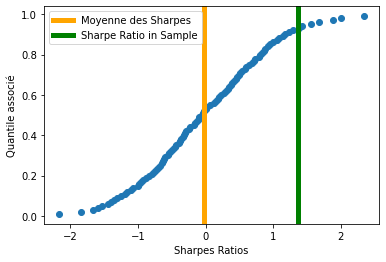

In [368]:
quantiles = sharpe_out_sample_DF_ridge.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])

moyenne_sharpe = float(sharpe_out_sample_DF_ridge.mean())
sharpe_in_sample = pnl_in_sample_ridge.mean()/pnl_in_sample_ridge.std()*16
plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')
plt.axvline(x=sharpe_in_sample, color='green', linestyle='-', linewidth=5,  label='Sharpe Ratio in Sample')

plt.xlabel('Sharpes Ratios')
plt.ylabel('Quantile associé')
plt.legend()
print(f"Voici le sharpe moyen de cette méthode {moyenne_sharpe}")

Pareil avec le LASSO. On utilise Lasso() et non LassoCV() car la pénalisation choisie est trop forte et mène à ne choisir d'investir dans aucun actif

[16.40382169  0.         -7.50491663  0.          0.         -0.
 -6.12779128  1.10580448 -1.80417447 -0.          0.         -7.02558676
 -0.          1.14438409  2.80845888 -0.         -0.         -0.
 -0.          0.        ]


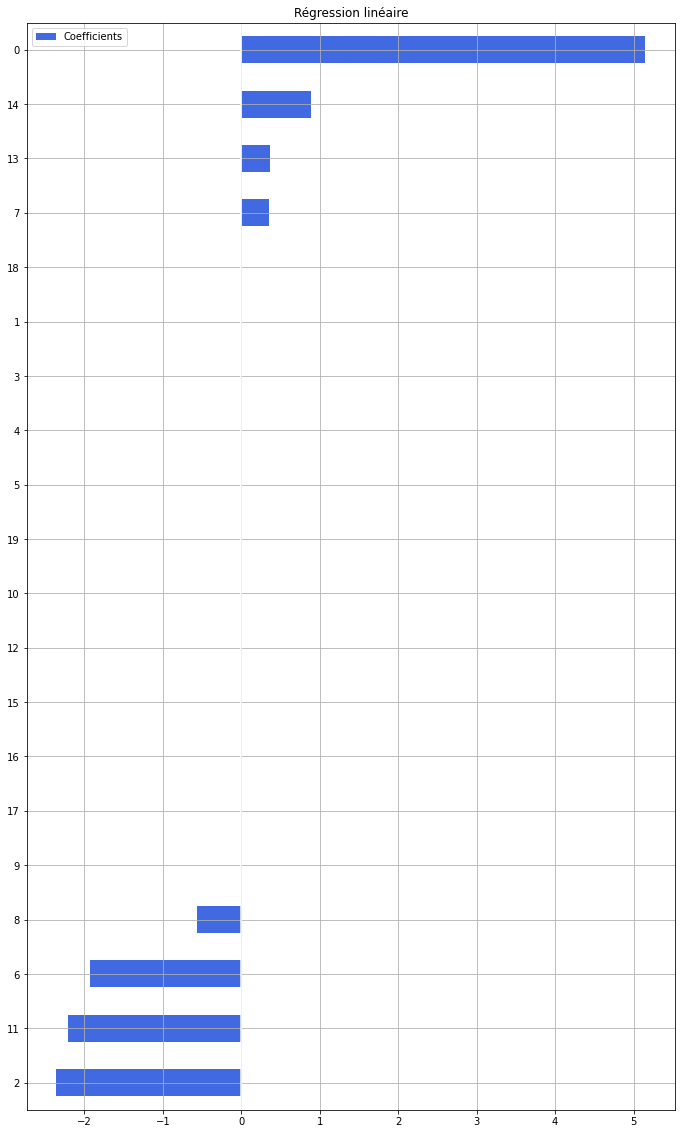

In [361]:
lasso = Lasso(fit_intercept = False, alpha = 0.0001)
model_lasso =  lasso.fit(X_train, Y_train)
coef_lasso = model_lasso.coef_

coefs = pd.DataFrame(coef_lasso, columns=['Coefficients'], index = X_train.columns)
coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
coefs.plot(kind='barh', figsize=(15, 20), color='royalblue')
plt.title('Régression linéaire')
plt.axvline(x=0, color='1')
plt.grid()
plt.subplots_adjust(left=.3)

#On rend les coefficients normalisés pour que le poid soit égal à 1
coef_lasso_normalized = coef_lasso * abs(1/sum(coef_lasso))
print(coef_lasso_normalized)

Sharpe = 1.215031885351405


<AxesSubplot:>

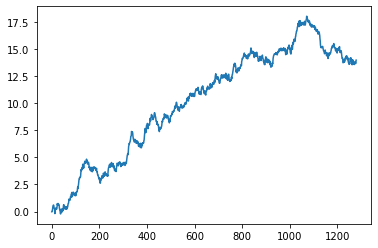

In [362]:
pnl_in_sample_lasso = rdts_observes @ coef_lasso_normalized
print('Sharpe = ' + str(pnl_in_sample_lasso.mean()/pnl_in_sample_lasso.std()*16))
pnl_in_sample_lasso.cumsum().plot()

Sharpe = 0.9205581837152358


<AxesSubplot:>

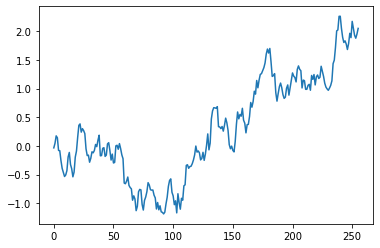

In [363]:
pnl_test_lasso = X_test @ coef_lasso_normalized
print('Sharpe = ' + str(pnl_test_lasso.mean()/pnl_test_lasso.std()*16))
pnl_test_lasso.cumsum().plot()

In [364]:
pnl_out_sample_lasso = []
sharpe_out_sample_lasso = []

for i in range(nb_simu) : 
    simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
    pnl_simu = simu @ coef_lasso_normalized
    pnl_out_sample_lasso.append(pnl_simu)

    sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
    sharpe_out_sample_lasso.append(sharpe_simu)

sharpe_out_sample_DF_lasso = pd.DataFrame(sharpe_out_sample_lasso)
sharpe_out_sample_DF_lasso.describe()

,0
count,1000.000000
mean,0.044159
std,0.978829
min,-3.009979
25%,-0.593717
50%,0.047615
75%,0.649069
max,3.014718


voici le sharpe moyen de cette méthode 0.044159125222313265


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/940539074.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF_lasso.mean())


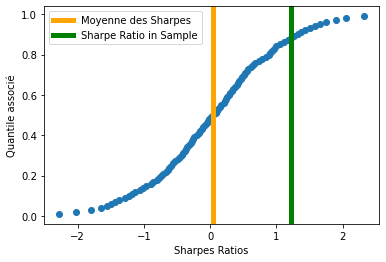

In [367]:
quantiles = sharpe_out_sample_DF_lasso.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])

moyenne_sharpe = float(sharpe_out_sample_DF_lasso.mean())
sharpe_in_sample = pnl_in_sample_lasso.mean()/pnl_in_sample_lasso.std()*16
plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')
plt.axvline(x=sharpe_in_sample, color='green', linestyle='-', linewidth=5,  label='Sharpe Ratio in Sample')

plt.xlabel('Sharpes Ratios')
plt.ylabel('Quantile associé')
plt.legend()
print(f"Voici le sharpe moyen de cette méthode {moyenne_sharpe}")

Comparaison des coefficients obtenus avec la régression classique et la régression Ridge/LASSO (normalisés)

In [365]:
print(coef_reg_lin_normalized)
print(coef_ridge_normalized)
print(coef_lasso_normalized)

[ 27.36263493   5.34158996 -15.80666153   5.11421438   5.18493812
  -6.33439121 -14.03209402  10.98708531 -10.12355826  -3.05338128
   3.84214709 -14.36889779  -2.12193112   9.8647389   11.56885755
  -4.59938055  -1.44751306  -5.2169724   -6.086866     2.925441  ]
[ 7.28355836  1.1741871  -4.17467815  1.46558463  0.86105933 -1.65303604
 -3.74431799  2.64783241 -2.47356096 -0.70826929  1.13457645 -4.05152748
 -0.54579644  2.5558027   3.16738835 -1.28302577 -0.48571434 -1.57161687
 -1.60577666  1.00733065]
[16.40382169  0.         -7.50491663  0.          0.         -0.
 -6.12779128  1.10580448 -1.80417447 -0.          0.         -7.02558676
 -0.          1.14438409  2.80845888 -0.         -0.         -0.
 -0.          0.        ]


### B/Changements des paramètres et impact sur le sharpe ratio

Création fonction qui génère le tableau des rendements en ayant la possibilité de changer les paramètres :
- Nombre d'actifs
- Nombre de dates
- Nombre de sous classes d'actifs avec leurs lois

In [468]:
def generation_tableau_rdts(nb_actifs, nb_dates, list_esp_rdts, list_vols, nb_simu, nb_dates_test, model) :     
    #Définition des lois des actifs
    idx = pd.Index(np.arange(nb_actifs))
    idx_date = pd.Index(np.arange(nb_dates))
    mu = np.zeros(nb_actifs)
    nb = len(list_esp_rdts)
    vol = np.zeros(nb_actifs)

    for i in range(nb):
        valeur_commune_mu = list_esp_rdts[i]
        debut_bloc = i * (nb_actifs // nb)
        fin_bloc = (i + 1) * (nb_actifs // nb)
        mu[debut_bloc:fin_bloc] = valeur_commune_mu
    
    for i in range(nb):
        valeur_commune_vol = list_vols[i]
        debut_bloc = i * (nb_actifs // nb)
        fin_bloc = (i + 1) * (nb_actifs // nb)
        vol[debut_bloc:fin_bloc] = valeur_commune_vol

    correl = 0.7

    #Matrice var-covar théorique selon la vraie loi des rendements
    covar = np.diag(vol) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vol)

    #On simuler un tirage de rendements suivant une loi normale d'espérence Mu et de Var la matrice Covar
    A = np.linalg.cholesky(covar)
    rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16
    Y_train = pd.Series(1, index = idx_date)

    model_ =  model.fit(rdts_observes, Y_train)
    coeffs = model_.coef_

    #On rend les coefficients normalisés pour que le poid soit égal à 1
    coef_normalized = coeffs * abs(1/sum(coeffs))
    
    #On va sortir le graphique avec les sharpe moyens 
    pnl_out_sample = []
    sharpe_out_sample = []

    #Ici, j'ai tout remplacé par les coefficients non normalisés afin de voir si cela réduit la variance des résultats
    for i in range(nb_simu) : 
        simu = mu/256 + pd.DataFrame(np.random.randn(nb_dates_test,nb_actifs)) @ A.T / 16
        pnl_simu = simu @ coef_normalized
        pnl_out_sample.append(pnl_simu)

        sharpe_simu = pnl_simu.mean() / pnl_simu.std() * 16
        sharpe_out_sample.append(sharpe_simu)

    sharpe_out_sample_DF = pd.DataFrame(sharpe_out_sample)
    sharpe_out_sample_DF.describe()
    print(sharpe_out_sample)

    quantiles = sharpe_out_sample_DF.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
    plt.scatter(quantiles['quantile'],quantiles['proba'])

    moyenne_sharpe = float(sharpe_out_sample_DF.mean())
    plt.axvline(x=moyenne_sharpe, color='orange', linestyle='-', linewidth=5,  label='Moyenne des Sharpes')

    plt.xlabel('Sharpes Ratios')
    plt.ylabel('Quantile associé')
    plt.legend()
    print(f"Voici le sharpe moyen de cette méthode {int(moyenne_sharpe*1000)/1000}")

    return f"Voici le portfolio optimal selon cette méthode : {coef_normalized}"

Testons la régression LARSE

Voici le sharpe moyen de cette méthode 0.154


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/4294134321.py:55: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-0.91933942  0.39671469 -0.21976095 -0.62762773  0.31748475  0.42873008\n -0.11756464  0.06976187  0.67503384  0.89947461 -0.35360925 -0.31923751\n -0.29492437 -0.88844491 -0.42079923  0.72682771 -0.19040001  1.46243884\n  0.20997186  0.16526977]'

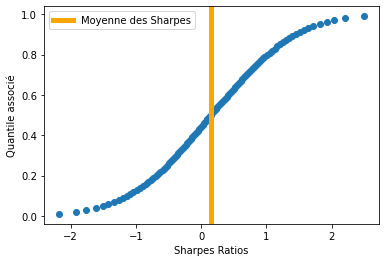

In [467]:
generation_tableau_rdts(20, 256*5, [0.05], [0.2], 25000, 256, Lars(fit_intercept=False))

Nous pouvons désormais faire varier les différents paramètres, complexifier les lois des différents actifs et comparer les sharpes moyen des différentes méthodes. 

Voici le sharpe moyen de cette méthode 0.3431323828169483


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-0.         -0.41581764 -0.         -0.         -0.         -0.\n  0.          0.57245956  0.84335808]'

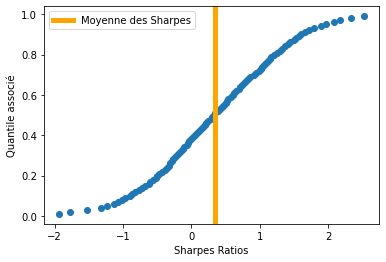

In [407]:
generation_tableau_rdts(9, 10000, [0.05, 0.03, 0.1], [0.2, 0.15, 0.3], 1000, 256, Lasso(fit_intercept=False, alpha = 0.0001))

Nous allons tester méthodiquement l'impact de la variation des différents paramètres sur le sharpe ratio out sample. Tout d'abord, faisons varier le nombre d'actifs. 

[-0.7598146729804351, -0.34718523702387966, -0.19394792478153988, 1.768439814087314, -1.0597807593838533, 0.04176987136413377, -1.0703114186502876, 0.46652609170152887, 0.1186114587628855, 0.41564894658506085, -0.12473321915048488, -0.7387826904097505, -0.5230250513673762, -0.47051741864540353, -0.8829737924167746, 2.2833110313196254, -0.12170735860470201, -0.02011597607397447, -0.15306399682850397, 0.5900884569191228, -2.36790297074617, -0.15872860034047645, 0.32284910344923823, -0.4289761506421542, -0.1426162365817916, 0.5940314148236945, 0.28612853208530875, -0.7314584721448929, -1.3171660741184243, 1.4913483012961306, -1.1844346481880947, -0.28035407617090535, 0.5316308159821597, 1.0827532470989447, 0.7305639640468284, 0.6090730703929539, 1.4222036029083565, -0.5716306144902019, 0.096814644673655, 1.832183372697381, -1.5821929980378486, 1.6712967360396616, 1.3214084448630377, -0.8931182363296796, 0.650608756286614, -0.08923439790388066, 2.008158802179987, -1.2340140961229302, -0.73

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/3766806837.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-0.64056567 -1.3990234   0.35102493  1.63445566  1.14199708 -1.35570637\n  1.58905506 -0.24359643  1.59324781]'

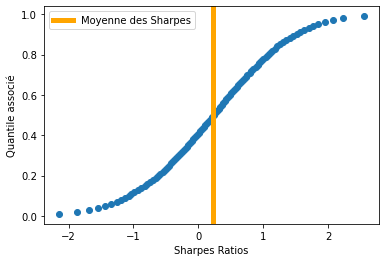

In [470]:
generation_tableau_rdts(9, 256*5, [0.05], [0.2], 10000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode -0.15416561164266593


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-0.57657187  0.21524243  0.18920282 -0.6940877   0.0533382  -0.14991035\n  0.46608061 -0.04038574  0.02934874 -0.66534764 -0.77616472 -1.30520929\n -0.44597116  1.15461311 -0.0862489   0.23938363  0.80654706  0.58614078]'

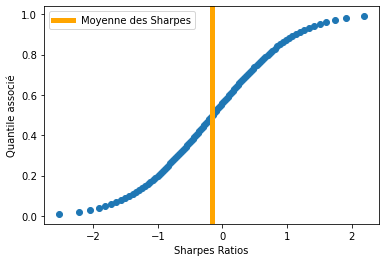

In [446]:
generation_tableau_rdts(18, 256*5, [0.05], [0.2], 70000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode -0.02658094985850156


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 0.9885139   1.76818424  2.52935298 -2.80266034  0.32561016  2.05381804\n -2.98738302 -5.39289705 -7.12746749 -1.61524474  1.18811633 -3.89075471\n  1.01259193  3.25699989  2.52763946 -2.61780433 -2.97095333  0.1675653\n  4.48849416  5.22761351  1.00503048  0.03074542 -3.12011765  1.50917506\n  3.89883781  9.60905097  1.3775425  -2.7300347  -3.85904315 -4.85052164]'

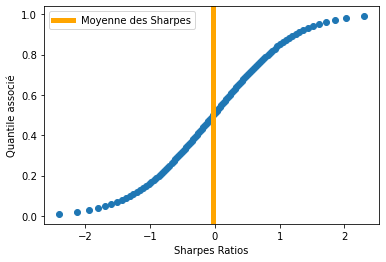

In [447]:
generation_tableau_rdts(30, 256*5, [0.05], [0.2], 80000, 256, RidgeCV(fit_intercept=False, cv = 5))

Maintenant, nous allons faire varier le nombre de dates d'historique utilisé : 1 an puis 10 ans d'historique d'entrainement

Voici le sharpe moyen de cette méthode 0.271899673441692


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 0.17238099 -0.08501178  0.38392575 -0.13794707  0.0498433   0.39333734\n  0.08303856  0.1052354   0.03519749]'

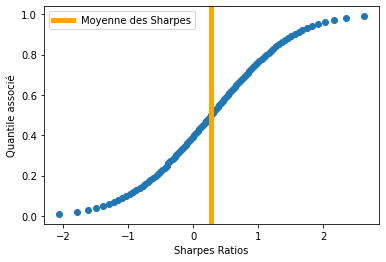

In [448]:
generation_tableau_rdts(9, 256, [0.05], [0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode -0.24198294434166398


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [-0.53309884  0.05982888  0.15870782 -0.14207787 -0.12595298  0.0072625\n  0.01916559  0.25353996  0.01613312 -0.04043147  0.0115354  -0.10684604\n -0.02246316 -0.09477605  0.38146699 -0.17589292 -0.37816993 -0.00145208\n -0.16135749 -0.27717613  0.21191878  0.23495367  0.0105104   0.12436093\n -0.11904083 -0.01965335 -0.03190075 -0.03717175 -0.23516996  0.01324754]'

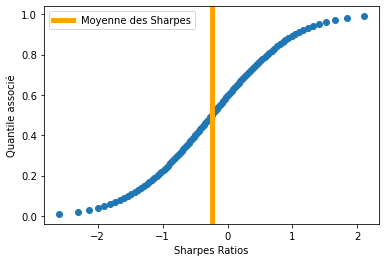

In [449]:
generation_tableau_rdts(30, 256, [0.05], [0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode 0.17109907591629964


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 0.49932501  0.30875966 -0.17557984  0.32383537 -0.79761643  0.18971498\n -0.87771447  1.56475607 -0.03548035]'

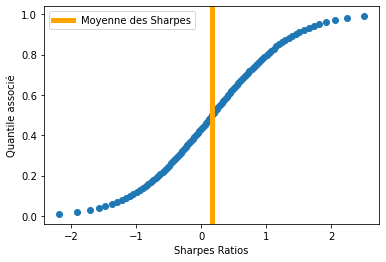

In [450]:
generation_tableau_rdts(9, 256*10, [0.05], [0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode 0.14360012883037088


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 0.07976665  0.24707071  0.38056582 -0.27214304 -0.28398011  0.5675454\n  0.38497173  0.9502852  -0.95604145  0.80752555  0.33087663 -0.59377432\n -0.29351687 -0.61347475  0.0118033  -0.59551707 -0.15653839  0.637963\n  0.04904189  0.02465925  0.24172544 -0.47322639 -0.87670125  0.40287753\n  0.71124557 -0.91027063  0.78339787  0.42777459  0.13099311 -0.14490496]'

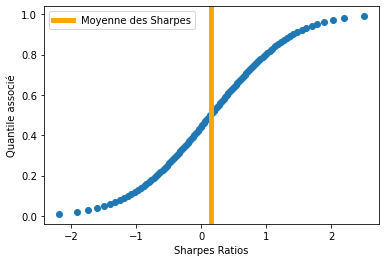

In [451]:
generation_tableau_rdts(30, 256*10, [0.05], [0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

Enfin, nous allons faire varier les lois des actifs en les scidant en deux groupes : Deux niveaux de rendements distincts pour la même variance et 2 niveaux de variance distincts pour le même rendement. 

Voici le sharpe moyen de cette méthode 0.4370299337657975


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 0.39243119 -1.96590498 -1.45458222 -0.90208809  0.33913449 -1.36777873\n -0.89914229 -2.33982296 -0.87509448  0.76611285  0.33273413  1.10820425\n  2.04642784 -0.02082263 -1.97301079  2.22534378  1.20776204  2.38009659]'

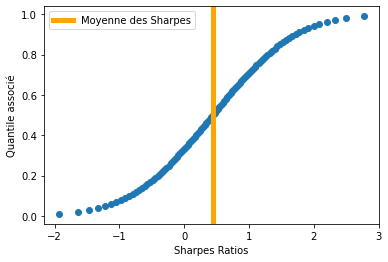

In [457]:
generation_tableau_rdts(18, 256*10, [0.02, 0.06], [0.2, 0.2], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))

Voici le sharpe moyen de cette méthode 0.38027096676305056


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_56304/2212029604.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  moyenne_sharpe = float(sharpe_out_sample_DF.mean())


'Voici le portfolio optimal selon cette méthode : [ 0.35196594 -0.09418074 -0.21018786 -0.37344118  0.64331424 -0.65743516\n -0.02065273 -0.26037005  0.51796917  0.45647861 -0.48246738 -0.25191858\n -0.09389188  0.00952734 -0.11149285  0.64067813  0.98280618 -0.04670119]'

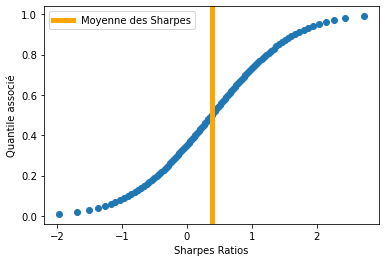

In [458]:
generation_tableau_rdts(18, 256*10, [0.05], [0.1, 0.3], 50000, 256, RidgeCV(fit_intercept=False, cv = 5))